In [3]:
# IMPORT SECTION
import pandas as pd
from util_data_exploration import read_CBS_excel
import geopandas as gpd
import difflib  # for comparing deltas and similar-looking matching
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.optimize import curve_fit
import os

In [4]:
'''
read excel files from CBS data, mostly down to buurt_level:
n_addresses : number of addresses (in lieu of households)
surface_areas : total area within buurt
median_prices : median house prices (probably depreciated)

'''

n_addresses = read_CBS_excel("data/Bewoonde adressen - Buurten.xlsx",
                             index_name='buurt',
                             convert_to_Int64=True)
surface_areas = read_CBS_excel("data/Oppervlakte  - 2020 - Buurten.xlsx", index_name='buurt', convert_to_Int64=True)
median_prices = read_CBS_excel("data/Mediane verkoopprijs - Buurten.xlsx", index_name='buurt', convert_to_Int64=True)
# highest20_percentile = read_CBS_excel("data/20% huishoudens met hoogste inkomen - Buurten.xlsx", index_name='buurt',
#                                       convert_to_Int64=False)
# lowest40_percentile = read_CBS_excel("data/40% huishoudens met laagste inkomen - Buurten.xlsx", index_name='buurt',
#                                      convert_to_Int64=False)
transactions = read_CBS_excel("data/Aantal transacties - Buurten.xlsx",
                              index_name='buurt', convert_to_Int64=True)
companies = read_CBS_excel("data/Bedrijfsvestigingen naar SBI 1 niveau - Buurten.xlsx", index_name='buurt',
                           convert_to_Int64=True)
house_index_macro = pd.read_csv("data/Bestaande_koopwoningen__regio___17052022_094557.csv",
                                sep=';', header=0, index_col=0)
rdam_price_2018 = house_index_macro.loc[2018, 'Gemiddelde verkoopprijs (euro)']

d:\Users\fishe\miniconda3\envs\tpm-aabm\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Users\fishe\miniconda3\envs\tpm-aabm\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


FileNotFoundError: [Errno 2] No such file or directory: 'data/20% huishoudens met hoogste inkomen - Buurten.xlsx'

In [ ]:
# national income brackets from CBS, x1000
income_brackets = (
        pd.read_csv("data/Inkomen_van_huishoudens__inkomensklassen__huishoudenskenmerken_20062022_161158.csv",
                    sep=';', header=0, index_col=0, decimal=',') * 1000).astype(int)
income_brackets.index = ['<10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '50k-100k', '100k-200k', '>200k']
income_brackets['min'] = [0, 1e4, 2e4, 3e4, 4e4, 5e4, 1e5, 2e5]
income_brackets['max'] = [1e4, 2e4, 3e4, 4e4, 5e4, 1e5, 2e5, 1e6]
# OPTIONAL: drop row of >200k since very small number
income_brackets = income_brackets.drop('>200k', axis=0)
# change to ratios?
# sns.displot(income_brackets, x=income_brackets.index,y='households')

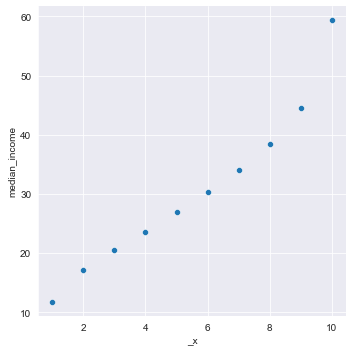

In [5]:
# national income brackets in deciles, per 1k euro
income_deciles = pd.read_csv('data/Inkomen_van_huishoudens__median.csv',
                             sep=';', header=0, index_col=0, decimal=',')
income_deciles.index = list(range(1, 10 + 1, 1))
income_deciles_dpre-notebook.ipynbelta = income_deciles.median_income[1:].to_numpy() - income_deciles.median_income[:-1].to_numpy()
sns.relplot(y=income_deciles.median_income, x=income_deciles.index)

In [ ]:
# create brute force function for quantiles
seed = 1
n_to_generate = 1000
lookup = income_deciles.median_income.to_numpy()
basic = list(range(1, 100, 10))  # plot to 100
generator = np.random.default_rng(seed=seed)
generations = generator.random(size=n_to_generate) * 10  # check whether np.float32 is valid
ints = generations.astype(int)
decimals = generations - ints


# TODO: relearn type hinting
def something(integer, decimal, lookup=lookup):
    # create function
    return lookup[integer] + decimal * (lookup[integer + 1] - lookup[integer])

# results = np.vectorize(something)(ints,decimals)
# then visualise the distribution for N generations

In [ ]:
# using the Excel-based 3rd-order regression technique
def curve_3(x):
    return 0.1199 * x * x * x - 14.5822 * x * x + 834.5435 * x + 7575.5915


def curve_4(x):
    return 0.0018 * x * x * x * x - 0.2391 * x * x * x + 8.6614 * x * x + 305.0563 * x + 10461.0723


def curve_3_b(x):
    # derived from good ol' Excel with besteedbare inkomen data
    return 0.1807 * x * x * x - 18.6247 * x * x + 1074.5260 * x + 7334.1725


curve_test = np.vectorize(curve_3)(generations)
curve_3_plot = np.vectorize(curve_3)(basic)
curve_4_plot = np.vectorize(curve_4)(basic)
curve_3_b_plot = np.vectorize(curve_3_b)(basic)


In [ ]:
"""
Simple method: drop the
only preserve relevant dataframes:
(transactions shouldn't be the constraint now)


"""
transactions_18 = transactions.loc[:, '2018'].dropna(how='all').rename('transactions')
median_prices_empties = median_prices.index[median_prices.isnull().all(axis=1)]  # gets row indices with full Null row
highest20_percentile_18 = highest20_percentile.loc[:, '2018'].rename('high20')  # get 2018 data (latest)
lowest40_percentile_18 = lowest40_percentile.loc[:, '2018'].rename('low40')
median_prices_18 = median_prices.loc[:, '2018'].rename('median')
n_addresses_18 = n_addresses.loc[:, '2018'].rename('n_address')
land_areas = surface_areas.loc[:, 'land']
companies_18 = companies.loc[:, '2018'].dropna().rename('companies')
density_companies = (companies_18 / land_areas).rename('density_companies')
density_households = (n_addresses_18 / land_areas).rename('density_households')
price_index = (median_prices_18 / rdam_price_2018).rename('price_delta')
# derive middle income bracket 40% from lowest 40% and highest 20%
middle40 = pd.Series(data=(1 - lowest40_percentile_18 - highest20_percentile_18), name='mid40')

households_p_bracket = pd.concat([lowest40_percentile_18, middle40, highest20_percentile_18], axis=1).mul(
    n_addresses_18, axis=0).round(0).astype('Int64')
households_p_bracket.columns = ['low40_hholds', 'mid40_hholds', 'high20_hholds']

## merge into big descriptive dataframe
descriptive = pd.concat(
    [lowest40_percentile_18, middle40, highest20_percentile_18, households_p_bracket, n_addresses_18,
     density_households, density_companies, median_prices_18, price_index, transactions_18], axis=1).dropna(how='any',
                                                                                                            subset=[
                                                                                                                'low40',
                                                                                                                'high20'])  # since mid40 is derived from low40 and high20, this is fine.


In [ ]:
# Looking at relations for mortgage
avg_home_value = [196.4, 196.9, 198.3, 210.1, 231.2, 249.5, 272.3, 328.6, 492.7]
avg_mortgage_value = [205.0,200.0,195.4,194.0,188.8,158.7,117.3,95.6,131.8]
x_values = list(range(1,10,1))
sns.relplot(x=x_values, y=avg_home_value)
sns.relplot(x=x_values, y=avg_mortgage_value)

In [ ]:
# experiment to see how many classes of agents required
descriptive.loc[:, ['low40_hholds', 'mid40_hholds', 'high20_hholds']].sum(axis=0)

In [ ]:
"""
Read vector data from rdam vector maps
"""
## maybe some visualisations to help
overwrite = True  # command to force overwrite
if 'buurten' not in locals() or overwrite:
    # open files for all buurten in NL
    buurten = gpd.read_file("data/WijkBuurtkaart_2020_v2/buurt_2020_v2.shp")
    # sort for Rdam
    rdam_buurten = buurten[buurten.GM_CODE == 'GM0599'].dropna(how='any')  # corresponds to Rdam, buurt only
    # rdam_buurt_2_wijk = rdam_buurten.copy()
    # extrarct only the geometry
    rdam_buurten = rdam_buurten[['BU_NAAM', 'WK_CODE', 'geometry']].set_index('BU_NAAM')
# rdam_buurten.plot()
# activate below to save the geometries for Rdam buurten
# rdam_buurten.to_file('data/Rdam_buurten_shape.shp')

# attempt to match rdam buurten index to descriptive dataframe
descriptive.index = descriptive.index.map(lambda x: difflib.get_close_matches(x, rdam_buurten.index)[0])
descriptive = gpd.GeoDataFrame(descriptive, geometry=rdam_buurten.loc[descriptive.index].geometry)
# descriptive = rdam_buurten.join(descriptive.astype(dtype='float64'),how='left')

In [ ]:
overwrite2 = True

if 'wijken' not in locals() or overwrite2:
    wijken = gpd.read_file('data/WijkBuurtkaart_2020_v2/wijk_2020_v2.shp')
    # filter for Rdam
    wijken = wijken[wijken.GM_CODE == 'GM0599'].dropna(how='any')
    # preserve only code, name and geometry
    wijken = wijken.loc[:, ['WK_CODE', 'WK_NAAM', 'geometry']]

    wijken.to_file('data/wijk_geometries.shp')

# TODO:use groupby and aggregation to get aggregation. Prolly need to have some mapping from the buurt data to the wijk data
# Create mapping from wijk code in buurt data to wijk name in wijk data
rdam_buurten['WK_NAAM'] = rdam_buurten.WK_CODE.map(wijken.set_index('WK_CODE').WK_NAAM)

In [ ]:
columns_to_plot = descriptive.columns[:-2].tolist()  # up to 'transactions'
# make figures with titles, and no axes
for idx, entry in enumerate(columns_to_plot):
    fig, ax = plt.subplots()
    descriptive.plot(column=entry, ax=ax, missing_kwds={'color': 'lightgrey'},
                     cmap='viridis')
    # ax.set_axis_off() # turn on for pretty plotting
    ax.set_title(f"{entry} within Rotterdam buurten")
    # fig.show()
    fig.savefig(f'data/choropleths_{entry}.jpg', dpi=800)
# fig.savefig('data/choropleths.jpg',dpi=600 )
# TODO: finish plots for choropleths with titling

In [ ]:
# Get choropleth of interesting values


# plot base map below, plot choropleth above

In [ ]:
"""
Get income distribution  of neighbourhoods
-> Used to translate to income distribution of agents
Also get number of agents per wijk/buurt
Could integrate number of agents per

Income table derived from onderzoek010 for proportion of brackets
Median income derived from CBS for deciles
Therefore, get distribution of agents (function?)

"""

